<a href="https://www.kaggle.com/code/dalloliogm/bank-autogluon?scriptVersionId=253672064" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Bank classification using Autogluon


Autogluon is a auto-ML library from Amazon. It can automatically try several approaches for prediction, and choose the optimal parameters given target metrics to optimize. It also automatically handles cross-validation, although that is not always enabled for all the presets.

How to improve this notebook:
- add more feature engineering
- Try different autogluon presets
- Plot results and inspect them

## Install Libraries and set Configuration

Installing Autogluon takes time, on Kaggle, but once that is done, we don't need anything else.

In [1]:
# %%capture
# !pip install -U autogluon

In [2]:
%%capture
!pip install -q xgboost==1.7.6 scikit-learn==1.3.2

In [3]:
# %%capture
import os
import shutil

target_dir = "/kaggle/working/"
source_dir = "/kaggle/input/autogluon-package/"

if not os.path.exists(os.path.join(target_dir, "autogluon")):
    shutil.copytree(source_dir, target_dir, dirs_exist_ok=True)
    print("Copied autogluon installation files.")

!pip install -f --quiet --no-index --find-links='/kaggle/input/autogluon-package' 'autogluon.tabular-1.3.1-py3-none-any.whl'


Copied autogluon installation files.
Looking in links: --quiet, /kaggle/input/autogluon-package
Processing ./autogluon.tabular-1.3.1-py3-none-any.whl
Processing /kaggle/input/autogluon-package/scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (from autogluon.tabular==1.3.1)
Processing /kaggle/input/autogluon-package/autogluon.core-1.3.1-py3-none-any.whl (from autogluon.tabular==1.3.1)
Processing /kaggle/input/autogluon-package/autogluon.features-1.3.1-py3-none-any.whl (from autogluon.tabular==1.3.1)
Processing /kaggle/input/autogluon-package/autogluon.common-1.3.1-py3-none-any.whl (from autogluon.core==1.3.1->autogluon.tabular==1.3.1)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following 

In [4]:
# Autogluon configuration. Automatically detects if we are using an interactive notebook, and use lower defaults when debugging
import os
import pandas as pd
import numpy as np
from autogluon.tabular import TabularPredictor

def is_interactive_session():
    return os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Interactive'

is_interactive_session()

config = {
    #                  minutes     seconds       # hours
    "autogluon_time": 60       *  60        *   0.2,
    "autogluon_preset": "best_quality",
    #"reduce_features": 0, # Set to >0 to use only the first n features
    "tail_rows": 0 # Set to >0 to use only the last n rows in the file. Useful for debugging
    
}

if is_interactive_session():
    print("Interactive session")
    config["autogluon_time"] = 100
    #config["reduce_features"] = 200
    config["autogluon_preset"] = "medium_quality"
    config["tail_rows"] = 2000
    print(config)
else:
    print("running as job")
    print(config)

running as job
{'autogluon_time': 720.0, 'autogluon_preset': 'best_quality', 'tail_rows': 0}


In [5]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### Autogluon parameters

In [6]:
hyperparameters = {
    'GBM': {},      # LightGBM
    'CAT': {},      # CatBoost
    'RF': {},       # RandomForest
    'XT': {},       # ExtraTrees
    'KNN': {},      # k-NN
    # 'NN': {},       # MXNet neural-net
    'LR': {},       # LinearModel
    'XGB': {        # XGBoost 
    },
    # 'TABPFN': {},
    'ENS_WEIGHTED' : {}
}

# 'RF', 'XT', 'KNN', 'GBM', 'CAT', 'XGB', 'NN_TORCH', 'LR', 'FASTAI', 'AG_TEXT_NN', 'AG_IMAGE_NN', 'AG_AUTOMM', 'FT_TRANSFORMER', 'TABPFN', 'TABPFNMIX', 'FASTTEXT', 'ENS_WEIGHTED', 'SIMPLE_ENS_WEIGHTED', 'IM_RULEFIT', 'IM_GREEDYTREE', 'IM_FIGS', 'IM_HSTREE', 'IM_BOOSTEDRULES', 'DUMMY']

## Load Data

In [7]:
import pandas as pd
# data
path        = '/kaggle/input/playground-series-s5e8/'
train       = pd.read_csv(path + 'train.csv',             index_col = 'id')
test        = pd.read_csv(path + 'test.csv',              index_col = 'id')
submission  = pd.read_csv(path + 'sample_submission.csv', index_col = 'id')

# Reduce dataset size for debugging
if config["tail_rows"] > 0:
    train = train.head(config["tail_rows"])

In [8]:
train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [9]:
test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
id,,,,,,,,,,,,,,,,
750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown


In [10]:
submission.head

<bound method NDFrame.head of           y
id         
750000  0.5
750001  0.5
750002  0.5
750003  0.5
750004  0.5
...     ...
999995  0.5
999996  0.5
999997  0.5
999998  0.5
999999  0.5

[250000 rows x 1 columns]>

# Set up Training

In [11]:
# 2) Fit all models under regression:
predictor = TabularPredictor(
    label='y',
    problem_type='binary',
    eval_metric="roc_auc",
).fit(
    train,
    hyperparameters=hyperparameters,
    time_limit = config["autogluon_time"],
    presets = config["autogluon_preset"]
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250801_121219"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       30.03 GB / 31.35 GB (95.8%)
Disk Space Avail:   16.00 GB / 19.52 GB (82.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be 

[1000]	valid_set's binary_logloss: 0.141103


	Ran out of time, early stopping on iteration 1073. Best iteration is:
	[1073]	valid_set's binary_logloss: 0.140958


[1000]	valid_set's binary_logloss: 0.145106


	Ran out of time, early stopping on iteration 1139. Best iteration is:
	[1137]	valid_set's binary_logloss: 0.144776


[1000]	valid_set's binary_logloss: 0.145075


	Ran out of time, early stopping on iteration 1235. Best iteration is:
	[1234]	valid_set's binary_logloss: 0.144648
	0.9684	 = Validation score   (roc_auc)
	293.95s	 = Training   runtime
	40.58s	 = Validation runtime
Fitting model: RandomForest_BAG_L1 ... Training model for up to 4.07s of the 178.41s of remaining time.
	Time limit exceeded... Skipping RandomForest_BAG_L1.
Fitting model: CatBoost_BAG_L1 ... Training model for up to 0.98s of the 175.32s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Time limit exceeded... Skipping CatBoost_BAG_L1.
Fitting model: ExtraTrees_BAG_L1 ... Training model for up to 0.32s of the 174.66s of remaining time.
	Time limit exceeded... Skipping ExtraTrees_BAG_L1.
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.00s of the 172.64s of remaining time.
	Ensemble Weights: {'LightGBM_BAG_L1': 0.958, 'KNeighbors_BAG_L1': 0.042}
	0.9684	 = Validation score   (roc_auc)
	8.48s	 = Tra

In [12]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM_BAG_L2,0.969094,roc_auc,50.223062,377.584679,2.980845,82.114653,2,True,4
1,WeightedEnsemble_L3,0.969094,roc_auc,50.357978,389.346925,0.134916,11.762246,3,True,5
2,WeightedEnsemble_L2,0.968449,roc_auc,47.395427,303.950011,0.153211,8.479985,2,True,3
3,LightGBM_BAG_L1,0.968371,roc_auc,40.576500,293.953061,40.576500,293.953061,1,True,2
4,KNeighbors_BAG_L1,0.875219,roc_auc,6.665716,1.516966,6.665716,1.516966,1,True,1


# Save Submission

In [13]:
preds = predictor.predict_proba(test)
preds

,0,1
id,,
750000,0.998405,0.001595
750001,0.916041,0.083959
750002,0.999807,0.000193
750003,0.999810,0.000191
750004,0.986081,0.013919
...,...,...
999995,0.999808,0.000192
999996,0.912134,0.087866
999997,0.293848,0.706152


In [14]:
preds = predictor.predict_proba(test)[1]  # Probability for class 1
submission['y'] = preds
submission = submission.reset_index()
# Save submission
submission.to_csv('submission.csv', index=False)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Predicted Y')

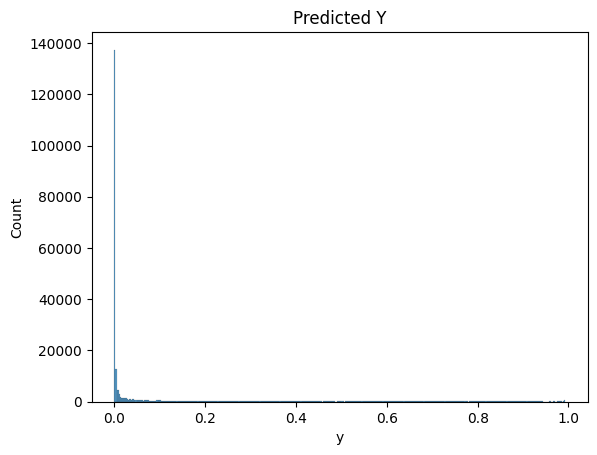

In [15]:
import seaborn as sns
sns.histplot(submission.y).set_title("Predicted Y")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Observed Y')

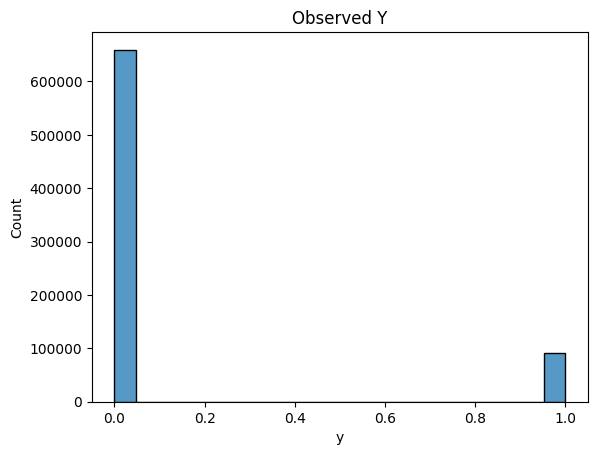

In [16]:
sns.histplot(train.y).set_title("Observed Y")